### Load the Dream Dataset

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint
import joblib

# 1. SETUP PATHS
INPUT_FILENAME = "dream_features_16h.parquet" 
INPUT_PATH = os.path.join('../data', INPUT_FILENAME)

# 2. LOAD DATA
if os.path.exists(INPUT_PATH):
    print(f"Loading dataset from {INPUT_PATH}...")
    df = pd.read_parquet(INPUT_PATH)
    print(f"Dataset Shape: {df.shape}")
else:
    raise FileNotFoundError(f"CRITICAL: File not found at {INPUT_PATH}. Please check the filename.")

Loading dataset from ../data\dream_features_16h.parquet...
Dataset Shape: (9282, 13)


### Prepare Training Data (X & y)

In [3]:
# 1. SEPARATE FEATURES AND TARGET
target_col = 'label'
X = df.drop(columns=[target_col])
y = df[target_col]

# 2. MAP LABELS (Standardizing to 0, 1, 2)
# -1 (Sell) -> 0
#  0 (Hold) -> 1
#  1 (Buy)  -> 2
label_mapping = {-1: 0, 0: 1, 1: 2}
y_mapped = y.map(label_mapping)

# 3. ALIGN DATA (Safety check for dropped rows)
common_index = X.index.intersection(y_mapped.index)
X_aligned = X.loc[common_index]
y_aligned = y_mapped.loc[common_index]

# 4. CREATE THE "VAULT" (Holdout Set)
# We split strictly by time. The last 20% is locked away.
split_point = int(len(X_aligned) * 0.80)

X_train = X_aligned.iloc[:split_point]
y_train = y_aligned.iloc[:split_point]

X_test_vault = X_aligned.iloc[split_point:]
y_test_vault = y_aligned.iloc[split_point:]

print(f"--- SPLIT COMPLETE ---")
print(f"Training Set : {len(X_train)} rows (Used for Grid Search)")
print(f"Vault Set    : {len(X_test_vault)} rows (Hidden for Final Test)")
print(f"\nTraining Class Balance:\n{y_train.value_counts(normalize=True)}")

--- SPLIT COMPLETE ---
Training Set : 7425 rows (Used for Grid Search)
Vault Set    : 1857 rows (Hidden for Final Test)

Training Class Balance:
label
2    0.378855
0    0.378182
1    0.242963
Name: proportion, dtype: float64


### Configure the Optimization (The "Thorough" Search)

In [4]:
# 1. VALIDATION STRATEGY (Internal CV on Training Data)
# 5 Splits with a 50-step gap to prevent overlap
tscv = TimeSeriesSplit(n_splits=5, gap=50)

# 2. SEARCH SPACE (Aggressive / High-Signal Config)
param_dist = {
    # Trees: 250-1000 for stability
    'n_estimators': randint(250, 1000),
    
    # Depth: 8-20 (Allowing deeper trees to find specific setups)
    'max_depth': randint(8, 20),
    
    # Leaf Size: 15-100 (Slightly lower min to catch more signals)
    'min_samples_leaf': randint(15, 100),
    
    # Randomness
    'max_features': ['sqrt', 'log2'],
    
    # Class Weight: Critical test. 
    # 'None' = let majority rule. 'balanced' = help the minority Hold.
    'class_weight': ['balanced', 'balanced_subsample', None],
    
    # Split Quality
    'criterion': ['gini', 'entropy']
}

print("Configuration Ready: Optimization will run on Training Set only.")

Configuration Ready: Optimization will run on Training Set only.


### Execute Random Search

In [5]:
# 1. INITIALIZE MODEL
rf = RandomForestClassifier(random_state=42)

# 2. INITIALIZE SEARCH
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,                   # 50 iterations for speed (bump to 100 for precision)
    scoring='f1_macro',          # Focus on balanced performance across Sell/Hold/Buy
    cv=tscv,
    verbose=1,
    random_state=42,
    # n_jobs=1                     # Single core to prevent Windows crash
)

# 3. RUN TRAINING
print(f"Starting optimization on {len(X_train)} rows...")
search.fit(X_train, y_train)

print("\n--- OPTIMIZATION COMPLETE ---")
print(f"Best CV Score (Macro F1): {search.best_score_:.4f}")
print("Best Parameters:", search.best_params_)

Starting optimization on 7425 rows...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- OPTIMIZATION COMPLETE ---
Best CV Score (Macro F1): 0.3994
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 91, 'n_estimators': 994}


### Final Evaluation & Feature Importance

### The "Honest Test" (Evaluation)

In [9]:
# 1. GET THE WINNER
best_model = search.best_estimator_

# 2. PREDICT ON VAULT DATA
print("Running prediction on Vault (Holdout) data...")
y_pred_vault = best_model.predict(X_test_vault)

# 3. CLASSIFICATION REPORT
target_names = ['Sell', 'Hold', 'Buy'] # 0, 1, 2
print("\n--- 🔒 HONEST TEST RESULTS ---")
print(classification_report(y_test_vault, y_pred_vault, target_names=target_names))

# 4. CONFUSION MATRIX
cm = confusion_matrix(y_test_vault, y_pred_vault)
print("\nConfusion Matrix:")
print(cm)

Running prediction on Vault (Holdout) data...

--- 🔒 HONEST TEST RESULTS ---
              precision    recall  f1-score   support

        Sell       0.40      0.40      0.40       680
        Hold       0.32      0.61      0.42       433
         Buy       0.45      0.20      0.28       744

    accuracy                           0.37      1857
   macro avg       0.39      0.41      0.36      1857
weighted avg       0.40      0.37      0.36      1857


Confusion Matrix:
[[274 281 125]
 [111 265  57]
 [302 293 149]]


In [10]:
import joblib
import datetime

# --- CONFIG FOR 16H MODEL ---
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
filename_16h = f'honest_model_16h_horizon_{timestamp}.joblib'

# Gather Metadata
bundle_16h = {
    'model': search.best_estimator_,
    'horizon': '16 Hours',
    'strategy': 'Patient/Slow (1.0x ATR)',
    'feature_names': list(X_train.columns),  # Saves exact column order from training
    'best_params': search.best_params_,
    'best_cv_score': search.best_score_,
    'description': "16h Horizon. Better Precision (0.45) but counter-trend confusion matrix.",
    'threshold_recommendation': 0.45 
}

# Save
joblib.dump(bundle_16h, filename_16h)

print(f"✅ SUCCESS: 16-Hour Model Bundle saved as:\n   {filename_16h}")
print("   (Contains model, features, params, and strategy notes)")

✅ SUCCESS: 16-Hour Model Bundle saved as:
   honest_model_16h_horizon_20251231_0649.joblib
   (Contains model, features, params, and strategy notes)


### Confidence Analysis

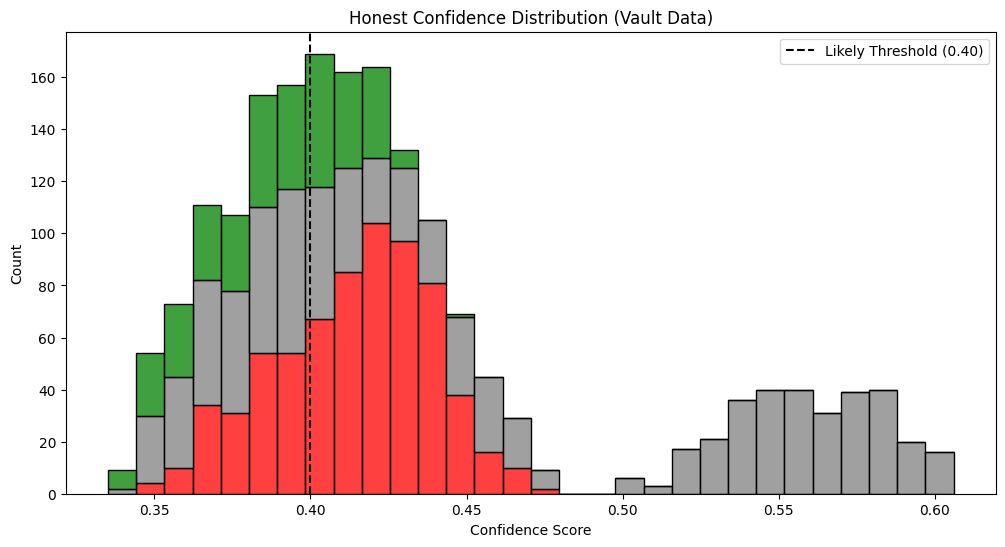


--- 💰 PROFITABILITY CHECK ---
Conf > 0.35 | Total Trades: 1819 | Buy Win Rate: 45.0%
Conf > 0.40 | Total Trades: 1166 | Buy Win Rate: 51.6%
Conf > 0.45 | Total Trades: 405 | Buy Win Rate: 0.0%
Conf > 0.50 | Total Trades: 307 | Buy Win Rate: 0.0%
Conf > 0.60 | Total Trades: 7 | Buy Win Rate: 0.0%


In [8]:
# 1. GET PROBABILITIES
probs_vault = best_model.predict_proba(X_test_vault)

# 2. CREATE ANALYSIS DATAFRAME
analysis_df = pd.DataFrame(probs_vault, columns=['Prob_Sell', 'Prob_Hold', 'Prob_Buy'])
analysis_df['Predicted'] = y_pred_vault
analysis_df['Actual'] = y_test_vault.values
analysis_df['Max_Confidence'] = analysis_df[['Prob_Sell', 'Prob_Hold', 'Prob_Buy']].max(axis=1)

# Map numeric labels to names for plotting
name_map = {0: 'Sell', 1: 'Hold', 2: 'Buy'}
analysis_df['Predicted_Label'] = analysis_df['Predicted'].map(name_map)
analysis_df['Actual_Label'] = analysis_df['Actual'].map(name_map)

# 3. PLOT CONFIDENCE HISTOGRAM
plt.figure(figsize=(12, 6))
sns.histplot(
    data=analysis_df,
    x='Max_Confidence',
    hue='Predicted_Label',
    multiple='stack',
    bins=30,
    palette={'Buy': 'green', 'Sell': 'red', 'Hold': 'gray'},
    hue_order=['Buy', 'Hold', 'Sell']
)
plt.axvline(0.40, color='black', linestyle='--', label='Likely Threshold (0.40)')
plt.title('Honest Confidence Distribution (Vault Data)')
plt.xlabel('Confidence Score')
plt.legend()
plt.show()

# 4. PROFITABILITY CHECK (Precision at Thresholds)
print("\n--- 💰 PROFITABILITY CHECK ---")
for t in [0.35, 0.40, 0.45, 0.50, 0.60]:
    subset = analysis_df[analysis_df['Max_Confidence'] > t]
    if len(subset) > 0:
        # Calculate Buy Precision
        buys = subset[subset['Predicted_Label'] == 'Buy']
        buy_prec = (buys['Predicted_Label'] == buys['Actual_Label']).mean() if len(buys) > 0 else 0
        print(f"Conf > {t:.2f} | Total Trades: {len(subset)} | Buy Win Rate: {buy_prec:.1%}")
    else:
        print(f"Conf > {t:.2f} | No trades.")

### Print the Best Parameters found by Grid Search

In [43]:
# 1. Print the Best Parameters found by Grid Search
print("--- Best Hyperparameters ---")
print(search.best_params_)

# 2. Print the Best Score (F1 Macro in this case)
print(f"Best Cross-Validation Score: {search.best_score_:.4f}")

# 3. (Optional) See the full Best Estimator object
best_model = search.best_estimator_

--- Best Hyperparameters ---
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 91, 'n_estimators': 994}
Best Cross-Validation Score: 0.3840
